## 02. Neural Network Classification with PyTorch

Classification is a problem of predicting whether something is one thing or another (there can be multiple options.)

In [23]:
import torch
from torch import nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# print(torch.__version__)
# print(np.__version__)

#### 1.0 Machine Learning Library : scikit-learn

In [24]:
import sklearn
import pandas as pd
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split

# print(sklearn.__version__)
# print(pd.__version__)

# make 1000 samples
n_samples = 1000

# create circles
X, y = make_circles(n_samples, # data imported from scikit learn
                    noise=0.03,
                    random_state=42)

# print(len(X), len(y))
# print(f"First 5 samples of X:\n {X[:5]}")
# print(f"First 5 samples of y:\n {y[:5]}")

# make dataframe of circle data
circles = pd.DataFrame({"X1": X[:, 0],
                         "X2": X[:, 1],
                         "label": y})

circles.head(10)
# print(circles.head(10))

# graphical visualization
"""
plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu)
"""


# print(type(X))
# print(type(y))
# print(X.dtype)
# print(y.dtype)

'\nplt.scatter(x=X[:, 0],\n            y=X[:, 1],\n            c=y,\n            cmap=plt.cm.RdYlBu)\n'

#### 1.1 Check input and output shapes

In [25]:
# print(X.shape, y.shape)
# X is a data in matrix form. y is a scalar (0 or 1)

# the given data is numerical values in different forms (vector, matrix, scalar)
# not tensors yet!!!

#### 1.2 Turn data into tensors and create train and test splits

In [26]:
# check given type (numpy.ndarray)
"""
print(type(X))
print(type(y))
print(X.dtype)
print(y.dtype)
"""

# change data type to tensor (torch.tensor)
X_T = torch.from_numpy(X).type(torch.float)
y_T = torch.from_numpy(y).type(torch.float)

"""
print("")
print(type(X_T))
print(type(y_T))
print(X_T.dtype)
print(y_T.dtype)
"""

# split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X_T,
                                                    y_T,
                                                    test_size=0.2,
                                                    random_state=12)

"""
print(X_test) # prints raw numpy data
print(X_train.shape)
print(len(X_train), len(X_test), len(y_train), len(y_test))
"""

'\nprint(X_test) # prints raw numpy data\nprint(X_train.shape)\nprint(len(X_train), len(X_test), len(y_train), len(y_test))\n'

#### 2.0 Building a Model

Build a model to classify blue and red dots of the circle.

To do:
1. Construct a model (by subclassing `nn.Module`) <b>= INHERITANCE</b>
2. Define a loss function and optimizer
3. Create a training a test loop

In [27]:
# setup device (later save and run via device)
device = "cpu" # we don't have cuda (gpu)

# subclass (inherit) nn.Module & construct model

class CircleModelV0(nn.Module):
    # constructor
    def __init__(self):
        super().__init__()

    # linear layer (use in foward method)
        self.layer_1 = nn.Linear(in_features=2, out_features=5)
        self.layer_2 = nn.Linear(in_features=5, out_features=1)

    # foward method
    def forward(self, x):
        return self.layer_2(self.layer_1(x))
    
model_0 = CircleModelV0().to(device)
# model_0

# use nn.Sequential to simplify model
model_seq = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

# model_seq

"""
print(model_0)
print(model_seq)
"""
with torch.inference_mode():
    untrained_predictions = model_0(X_test.to(device))
# print(untrained_predictions)
# print(y_test)

#### 2.1 Setting up Loss Function & Optimizer

1. Loss function measures how *wrong* your model's predictions are.
2. Based on the loss function, we minimize the output of the loss function by optimizer (e.g. Adam, SGD)
3. We will be using `torch.nn.BECWithLogitsLoss()` for the loss function. (BCE = Binary Cross Entropy)

In [28]:
# set loss function

# BCEWithLogitsLoss() has sigmoid built-in as activation function
loss_fn = nn.BCEWithLogitsLoss()

# set optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

# print(model_0.state_dict())
# print(model_0.parameters())

# calculate accuracy
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct/len(y_pred)) * 100

    return acc

#### 3.0 Train Model

1. Forward pass (built-in)
2. Calculate loss (BCE)
3. Backpropagation
4. Optimize (gradient descent)

#### 3.1 Convert logits into prediction probabilities

Convert **logits** by passing them through activation functions.

1. Binary Classification -> `Sigmoid`
2. Multiclass Classification -> `Softmax`

#### 3.2 Convert prediction probabilities into prediction labels

1. Round Probability
2. Take Max `argmax()`

In [29]:
# simple testing (first five)

"""
Whenever making predictions, turn model into eval mode and run inference mode. Turn model back into train mode for training.
"""

model_0.eval()
with torch.inference_mode():
    y_logits = model_0(X_test.to(device))[:5]

# print(y_logits)
# print(y_test[:5])

# different form! change logit to y_test form
# 3.1 process
y_pred_probs = torch.sigmoid(y_logits)
# print(y_pred_probs)

# round prediction probabilities
y_preds = torch.round(y_pred_probs)
# print(y_preds)

In [30]:
# All Together (logits -> pred probs -> pred labels)
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

#### 3.3 Train & Test

In [31]:
# gaurantee reproducibility (not necessary process)
torch.manual_seed(11)

# set number of epochs
epochs = 100

# put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# build training and evaluation loop
for epoch in range(epochs):
    # train mode
    model_0.train()

    # forward pass
    y_logits = model_0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    # calculate loss & accuracy
    # nn.BCEWithLogitsLoss expects raw logits as input
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train,
                      y_pred=y_pred)
    
    # set optimizer
    optimizer.zero_grad()

    # backward propagation
    loss.backward()

    # optimize (gradient descent, SGD)
    optimizer.step()

    # testing
    model_0.eval()
    with torch.inference_mode():
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)
        
    # print
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Train Loss: {loss: .5f}, Train Acc: {acc: .2f}% | Test Loss: {test_loss: .5f}, Test Acc: {test_acc: .2f}%")

Epoch: 0 | Train Loss:  0.70029, Train Acc:  54.37% | Test Loss:  0.70623, Test Acc:  51.00%
Epoch: 10 | Train Loss:  0.69751, Train Acc:  52.50% | Test Loss:  0.70233, Test Acc:  50.00%
Epoch: 20 | Train Loss:  0.69604, Train Acc:  52.12% | Test Loss:  0.70002, Test Acc:  49.50%
Epoch: 30 | Train Loss:  0.69518, Train Acc:  51.50% | Test Loss:  0.69853, Test Acc:  51.00%
Epoch: 40 | Train Loss:  0.69462, Train Acc:  51.62% | Test Loss:  0.69750, Test Acc:  52.00%
Epoch: 50 | Train Loss:  0.69424, Train Acc:  51.12% | Test Loss:  0.69676, Test Acc:  50.00%
Epoch: 60 | Train Loss:  0.69396, Train Acc:  51.12% | Test Loss:  0.69621, Test Acc:  50.50%
Epoch: 70 | Train Loss:  0.69375, Train Acc:  51.00% | Test Loss:  0.69579, Test Acc:  51.00%
Epoch: 80 | Train Loss:  0.69359, Train Acc:  51.00% | Test Loss:  0.69546, Test Acc:  51.00%
Epoch: 90 | Train Loss:  0.69346, Train Acc:  51.25% | Test Loss:  0.69520, Test Acc:  52.00%


#### 4.0 Fix Model

1. Model Failure
2. Visualize
3. Analyze Problem
4. Fix

helper_functions.py already exists, skipping download


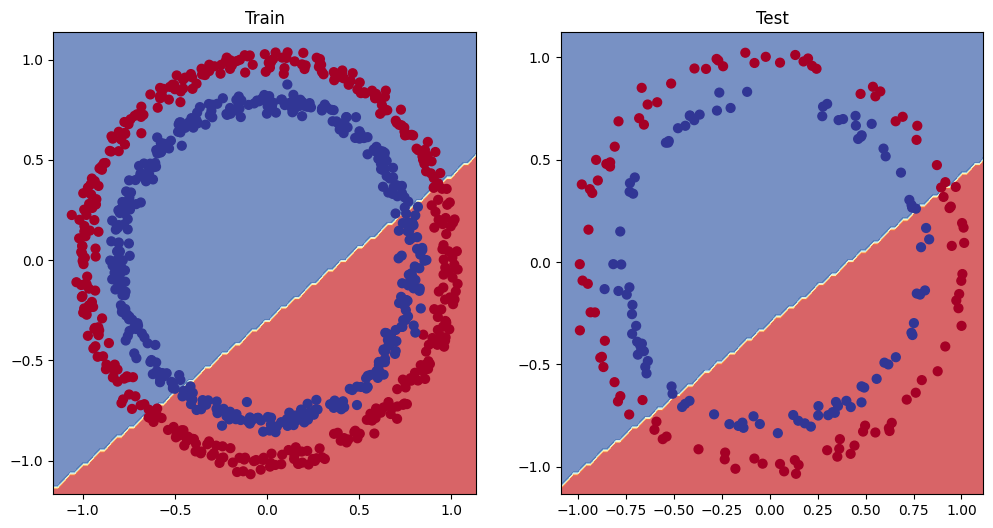

In [32]:
import requests
from pathlib import Path

# download helper functions from github repo
if Path("helper_functions.py").is_file():
    print("helper_functions.py already exists, skipping download")
else:
    print("Downloading helper_functions.py")
    # need raw url from github
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

# plot decision boundary of the model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)
